# Auto ARIMA - Array Interface Tutorial

This notebook demonstrates how to use the `auto_arima` function with NumPy arrays.
The array interface provides a lightweight, functional approach to automatic ARIMA model selection.

## Contents
1. [Setup and Imports](#setup)
2. [Basic Usage](#basic-usage)
3. [Understanding the Output](#output)
4. [Forecasting](#forecasting)
5. [Prediction Intervals](#prediction-intervals)
6. [Seasonal ARIMA](#seasonal)
7. [Box-Cox Transformations](#box-cox)
8. [Exogenous Variables](#exogenous)
9. [Stepwise vs Grid Search](#stepwise)

<a id='setup'></a>
## 1. Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
#print(path)
sys.path.insert(1, path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import skforecast
print(f"skforecast version: {skforecast.__version__}")

skforecast version: 0.19.1


In [2]:
# Import auto_arima and related functions
from skforecast.stats.arima import (
    auto_arima,
    forecast_arima,
    arima,
    ndiffs,
    nsdiffs,
)

# Import seasonal utilities
from skforecast.stats.seasonal import seas_heuristic

# Import transformations
from skforecast.stats.transformations import box_cox, inv_box_cox

### Load Sample Data

We'll use the classic AirPassengers dataset - monthly airline passenger numbers from 1949-1960.

In [3]:
# AirPassengers data
air_passengers = np.array([
    112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118,
    115, 126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140,
    145, 150, 178, 163, 172, 178, 199, 199, 184, 162, 146, 166,
    171, 180, 193, 181, 183, 218, 230, 242, 209, 191, 172, 194,
    196, 196, 236, 235, 229, 243, 264, 272, 237, 211, 180, 201,
    204, 188, 235, 227, 234, 264, 302, 293, 259, 229, 203, 229,
    242, 233, 267, 269, 270, 315, 364, 347, 312, 274, 237, 278,
    284, 277, 317, 313, 318, 374, 413, 405, 355, 306, 271, 306,
    315, 301, 356, 348, 355, 422, 465, 467, 404, 347, 305, 336,
    340, 318, 362, 348, 363, 435, 491, 505, 404, 359, 310, 337,
    360, 342, 406, 396, 420, 472, 548, 559, 463, 407, 362, 405,
    417, 391, 419, 461, 472, 535, 622, 606, 508, 461, 390, 432
], dtype=np.float64)

# Create date index for plotting
dates = pd.date_range(start='1949-01', periods=len(air_passengers), freq='MS')

print(f"Series length: {len(air_passengers)}")
print(f"Date range: {dates[0]} to {dates[-1]}")

Series length: 144
Date range: 1949-01-01 00:00:00 to 1960-12-01 00:00:00


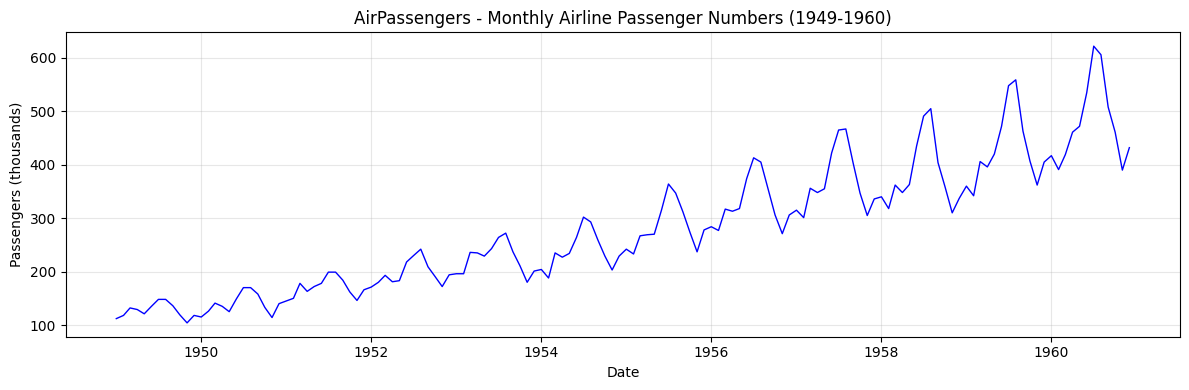

In [4]:
# Plot the data
plt.figure(figsize=(12, 4))
plt.plot(dates, air_passengers, 'b-', linewidth=1)
plt.title('AirPassengers - Monthly Airline Passenger Numbers (1949-1960)')
plt.xlabel('Date')
plt.ylabel('Passengers (thousands)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<a id='basic-usage'></a>
## 2. Basic Usage

The `auto_arima` function automatically selects the best ARIMA model by searching over different combinations of (p,d,q) and seasonal (P,D,Q) orders.

In [5]:
# Basic auto_arima call
# m=12 indicates monthly seasonality
fit = auto_arima(
    y=air_passengers,
    m=12,              # Seasonal period (12 for monthly data)
    trace=True         # Print search progress
)

 ARIMA(2,1,2)(1,1,1)[12]                    : 1027.4980
 ARIMA(0,1,0)(0,1,0)[12]                    : 1032.3779
 ARIMA(1,1,0)(1,1,0)[12]                    : 1021.4024
 ARIMA(0,1,1)(0,1,1)[12]                    : 1022.0267
 ARIMA(1,1,0)(0,1,0)[12]                    : 1021.2864
 ARIMA(1,1,0)(0,1,1)[12]                    : 1021.9185
 ARIMA(1,1,0)(1,1,1)[12]                    : 1022.4565
 ARIMA(2,1,0)(0,1,0)[12]                    : 1023.3816
 ARIMA(1,1,1)(0,1,0)[12]                    : 1023.3816
 ARIMA(0,1,1)(0,1,0)[12]                    : 1021.5496
 ARIMA(2,1,1)(0,1,0)[12]                    : 1018.4990
 ARIMA(2,1,1)(1,1,0)[12]                    : 1020.6831
 ARIMA(2,1,1)(0,1,1)[12]                    : 1020.0379
 ARIMA(2,1,1)(1,1,1)[12]                    : Inf
 ARIMA(3,1,1)(0,1,0)[12]                    : 1019.8967
 ARIMA(2,1,2)(0,1,0)[12]                    : 1020.2436
 ARIMA(1,1,2)(0,1,0)[12]                    : 1025.2860
 ARIMA(3,1,0)(0,1,0)[12]                    : 1024.798

<a id='output'></a>
## 3. Understanding the Output

The `auto_arima` function returns a dictionary containing the fitted model and all relevant information.

In [6]:
# View all keys in the result
print("Keys in auto_arima result:")
print(list(fit.keys()))

Keys in auto_arima result:
['y', 'fitted', 'coef', 'sigma2', 'var_coef', 'mask', 'loglik', 'aic', 'bic', 'aicc', 'arma', 'residuals', 'converged', 'n_cond', 'nobs', 'model', 'xreg', 'method', 'lambda', 'biasadj', 'offset', 'ic']


In [7]:
# Model order
print("Model Specification:")
print(f"  Order (p,d,q): {fit['arma'][:3]}")
print(f"  Seasonal Order (P,D,Q): {fit['arma'][3:6]}")
print(f"  Seasonal Period (m): {fit['arma'][6]}")

Model Specification:
  Order (p,d,q): [2, 1, 0]
  Seasonal Order (P,D,Q): [0, 12, 1]
  Seasonal Period (m): 1


In [8]:
# Coefficients
print("\nEstimated Coefficients:")
display(fit['coef'])


Estimated Coefficients:


,ar1,ar2,ma1
0,0.597345,0.218983,-0.990052


In [9]:
# Model fit statistics
print("\nModel Fit Statistics:")
print(f"  Log-likelihood: {fit['loglik']:.4f}")
print(f"  AIC: {fit['aic']:.4f}")
print(f"  AICc: {fit['aicc']:.4f}")
print(f"  BIC: {fit['bic']:.4f}")
print(f"  Sigma^2: {fit['sigma2']:.6f}")


Model Fit Statistics:
  Log-likelihood: -505.0908
  AIC: 1018.1815
  AICc: 1018.4990
  BIC: 1029.6823
  Sigma^2: 130.963242


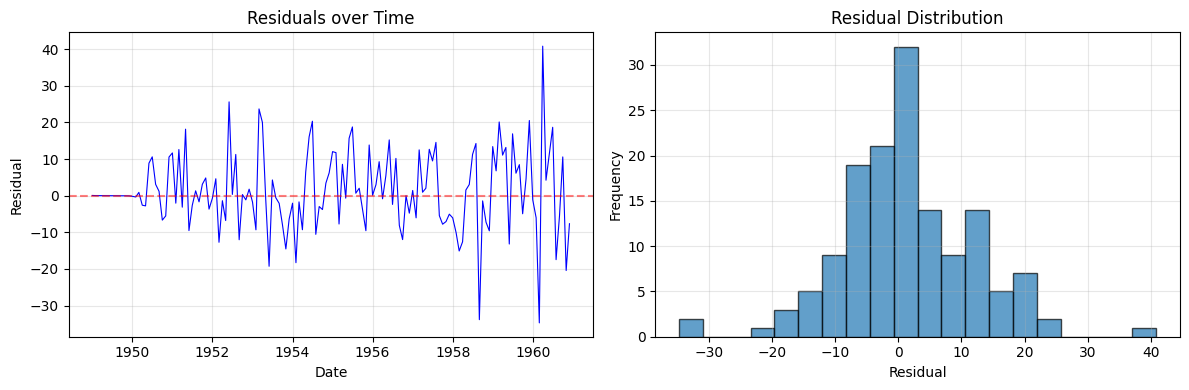

Residual Statistics:
  Mean: 1.2123
  Std: 10.7211


In [10]:
# Residuals
residuals = fit['residuals']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Residuals over time
axes[0].plot(dates, residuals, 'b-', linewidth=0.8)
axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0].set_title('Residuals over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Residual')
axes[0].grid(True, alpha=0.3)

# Residual histogram
axes[1].hist(residuals, bins=20, edgecolor='black', alpha=0.7)
axes[1].set_title('Residual Distribution')
axes[1].set_xlabel('Residual')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Residual Statistics:")
print(f"  Mean: {np.mean(residuals):.4f}")
print(f"  Std: {np.std(residuals):.4f}")

<a id='forecasting'></a>
## 4. Forecasting

Use `forecast_arima` to generate predictions from the fitted model.

In [11]:
# Generate 24-month forecast
h = 24  # Forecast horizon

forecast = forecast_arima(fit, h=h)

print("Forecast result keys:")
print(list(forecast.keys()))

Forecast result keys:
['mean', 'lower', 'upper', 'level', 'x', 'fitted', 'residuals', 'method', 'lambda', 'biasadj']


In [12]:
# Extract forecasts
pred_mean = forecast['mean']
pred_lower = forecast['lower']  # Lower prediction intervals
pred_upper = forecast['upper']  # Upper prediction intervals

# Create forecast dates
forecast_dates = pd.date_range(start=dates[-1] + pd.DateOffset(months=1), periods=h, freq='MS')

print(f"Forecast period: {forecast_dates[0]} to {forecast_dates[-1]}")
print(f"\nFirst 6 forecasts:")
for i in range(6):
    print(f"  {forecast_dates[i].strftime('%Y-%m')}: {pred_mean[i]:.1f}")

Forecast period: 1961-01-01 00:00:00 to 1962-12-01 00:00:00

First 6 forecasts:
  1961-01: 445.3
  1961-02: 419.8
  1961-03: 448.4
  1961-04: 490.9
  1961-05: 502.4
  1961-06: 565.7


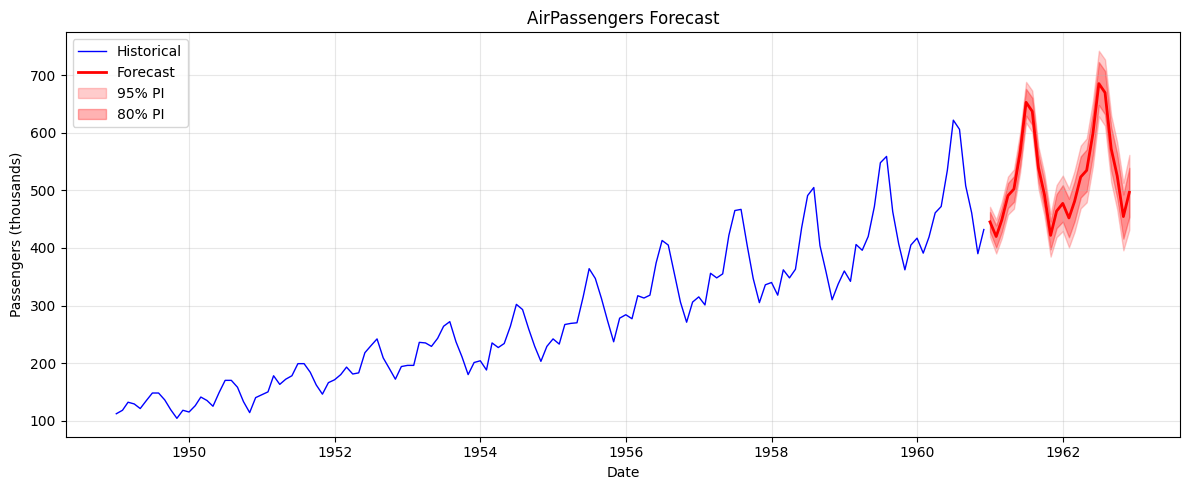

In [13]:
# Plot forecast
plt.figure(figsize=(12, 5))

# Historical data
plt.plot(dates, air_passengers, 'b-', linewidth=1, label='Historical')

# Forecast
plt.plot(forecast_dates, pred_mean, 'r-', linewidth=2, label='Forecast')

# Prediction intervals (80% and 95%)
plt.fill_between(forecast_dates, pred_lower[:, 1], pred_upper[:, 1], 
                 alpha=0.2, color='red', label='95% PI')
plt.fill_between(forecast_dates, pred_lower[:, 0], pred_upper[:, 0], 
                 alpha=0.3, color='red', label='80% PI')

plt.title('AirPassengers Forecast')
plt.xlabel('Date')
plt.ylabel('Passengers (thousands)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<a id='prediction-intervals'></a>
## 5. Prediction Intervals

You can customize the confidence levels for prediction intervals.

In [14]:
# Custom confidence levels
forecast_custom = forecast_arima(
    fit, 
    h=12, 
    level=[50, 80, 95, 99]  # Multiple confidence levels
)

print("Prediction interval levels:", forecast_custom['level'])
print(f"\nLower bounds shape: {forecast_custom['lower'].shape}")
print(f"Upper bounds shape: {forecast_custom['upper'].shape}")

Prediction interval levels: [50, 80, 95, 99]

Lower bounds shape: (12, 4)
Upper bounds shape: (12, 4)


In [15]:
# Display forecast table with intervals
forecast_df = pd.DataFrame({
    'Point Forecast': forecast_custom['mean'],
    'Lo 50': forecast_custom['lower'][:, 0],
    'Hi 50': forecast_custom['upper'][:, 0],
    'Lo 80': forecast_custom['lower'][:, 1],
    'Hi 80': forecast_custom['upper'][:, 1],
    'Lo 95': forecast_custom['lower'][:, 2],
    'Hi 95': forecast_custom['upper'][:, 2],
})
forecast_df.index = pd.date_range(start=dates[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
forecast_df.index.name = 'Date'

display(forecast_df.round(1))

,Point Forecast,Lo 50,Hi 50,Lo 80,Hi 80,Lo 95,Hi 95
Date,,,,,,,
1961-01-01,445.3,436.2,454.3,428.1,462.5,419.0,471.6
1961-02-01,419.8,409.7,430.0,400.6,439.1,390.4,449.3
1961-03-01,448.4,437.6,459.3,427.8,469.1,416.9,480.0
1961-04-01,490.9,479.6,502.3,469.3,512.5,457.9,524.0
1961-05-01,502.4,490.6,514.1,480.0,524.7,468.2,536.5
1961-06-01,565.7,553.7,577.7,542.9,588.6,530.8,600.7
1961-07-01,653.0,640.8,665.3,629.8,676.3,617.4,688.6
1961-08-01,637.3,624.9,649.7,613.7,660.8,601.2,673.3
1961-09-01,539.5,527.0,552.0,515.7,563.3,503.1,575.9


<a id='seasonal'></a>
## 6. Seasonal ARIMA

Control seasonal model selection with various parameters.

In [16]:
# Check seasonal strength
seasonal_strength = seas_heuristic(air_passengers, period=12)
print(f"Seasonal strength: {seasonal_strength:.3f}")
print(f"Seasonal differencing recommended: {seasonal_strength > 0.64}")

Seasonal strength: 0.766
Seasonal differencing recommended: True


In [17]:
# Determine differencing orders
d = ndiffs(air_passengers)
D = nsdiffs(air_passengers, period=12)

print(f"Recommended regular differencing (d): {d}")
print(f"Recommended seasonal differencing (D): {D}")

Recommended regular differencing (d): 1
Recommended seasonal differencing (D): 1


In [18]:
# Fit with custom constraints
fit_custom = auto_arima(
    y=air_passengers,
    m=12,
    d=1,               # Fix d=1
    D=1,               # Fix D=1
    max_p=3,           # Maximum AR order
    max_q=3,           # Maximum MA order
    max_P=2,           # Maximum seasonal AR order
    max_Q=2,           # Maximum seasonal MA order
    ic='aicc',         # Information criterion (aic, aicc, or bic)
    trace=True
)

 ARIMA(2,1,2)(1,1,1)[12]                    : 1027.4980
 ARIMA(0,1,0)(0,1,0)[12]                    : 1032.3779
 ARIMA(1,1,0)(1,1,0)[12]                    : 1021.4024
 ARIMA(0,1,1)(0,1,1)[12]                    : 1022.0267
 ARIMA(1,1,0)(0,1,0)[12]                    : 1021.2864
 ARIMA(1,1,0)(0,1,1)[12]                    : 1021.9185
 ARIMA(1,1,0)(1,1,1)[12]                    : 1022.4565
 ARIMA(2,1,0)(0,1,0)[12]                    : 1023.3816
 ARIMA(1,1,1)(0,1,0)[12]                    : 1023.3816
 ARIMA(0,1,1)(0,1,0)[12]                    : 1021.5496
 ARIMA(2,1,1)(0,1,0)[12]                    : 1018.4990
 ARIMA(2,1,1)(1,1,0)[12]                    : 1020.6831
 ARIMA(2,1,1)(0,1,1)[12]                    : 1020.0379
 ARIMA(2,1,1)(1,1,1)[12]                    : Inf
 ARIMA(3,1,1)(0,1,0)[12]                    : 1019.8967
 ARIMA(2,1,2)(0,1,0)[12]                    : 1020.2436
 ARIMA(1,1,2)(0,1,0)[12]                    : 1025.2860
 ARIMA(3,1,0)(0,1,0)[12]                    : 1024.798

In [19]:
# Non-seasonal ARIMA (set seasonal=False or m=1)
fit_nonseasonal = auto_arima(
    y=air_passengers,
    m=1,               # No seasonality
    seasonal=False,    # Disable seasonal component
    trace=True
)

print(f"\nNon-seasonal model AIC: {fit_nonseasonal['aic']:.2f}")
print(f"Seasonal model AIC: {fit['aic']:.2f}")

 ARIMA(2,1,2) with drift         : Inf
 ARIMA(0,1,0) with drift         : 1416.3542
 ARIMA(1,1,0) with drift         : 1404.6497
 ARIMA(0,1,1) with drift         : 1400.0034
 ARIMA(0,1,0)                    : 1414.9093
 ARIMA(1,1,1) with drift         : 1397.6293
 ARIMA(1,1,1)                    : 1396.0497
 ARIMA(0,1,1)                    : 1398.3478
 ARIMA(1,1,0)                    : 1402.9397
 ARIMA(2,1,1)                    : Inf
 ARIMA(1,1,2)                    : 1387.0479
 ARIMA(1,1,2) with drift         : Inf
 ARIMA(0,1,2)                    : 1398.1907
 ARIMA(2,1,2)                    : 1389.3956
 ARIMA(1,1,3)                    : Inf
 ARIMA(0,1,3)                    : 1395.8838
 ARIMA(2,1,3)                    : Inf

Best model found!

Non-seasonal model AIC: 1386.76
Seasonal model AIC: 1018.18


<a id='box-cox'></a>
## 7. Box-Cox Transformations

Box-Cox transformations can stabilize variance in the series.

In [20]:
# Fit with automatic Box-Cox transformation
fit_boxcox = auto_arima(
    y=air_passengers,
    m=12,
    lambda_bc='auto',  # Automatic lambda selection
    trace=True
)

print(f"\nSelected Box-Cox lambda: {fit_boxcox.get('lambda', 'N/A')}")

 ARIMA(2,1,2)(1,1,1)[12]                    : -476.0057
 ARIMA(0,1,0)(0,1,0)[12]                    : -434.5241
 ARIMA(1,1,0)(1,1,0)[12]                    : -474.0203
 ARIMA(0,1,1)(0,1,1)[12]                    : -482.1808
 ARIMA(0,1,1)(0,1,0)[12]                    : -449.6349
 ARIMA(0,1,1)(1,1,1)[12]                    : -480.5814
 ARIMA(0,1,1)(0,1,2)[12]                    : -480.6474
 ARIMA(0,1,1)(1,1,0)[12]                    : -476.4875
 ARIMA(0,1,1)(1,1,2)[12]                    : Inf
 ARIMA(0,1,0)(0,1,1)[12]                    : -466.4482
 ARIMA(1,1,1)(0,1,1)[12]                    : -480.5677
 ARIMA(0,1,2)(0,1,1)[12]                    : -480.2746
 ARIMA(1,1,0)(0,1,1)[12]                    : -480.2648
 ARIMA(1,1,2)(0,1,1)[12]                    : -479.7165

Best model found!

Selected Box-Cox lambda: 5.9608609865491405e-06


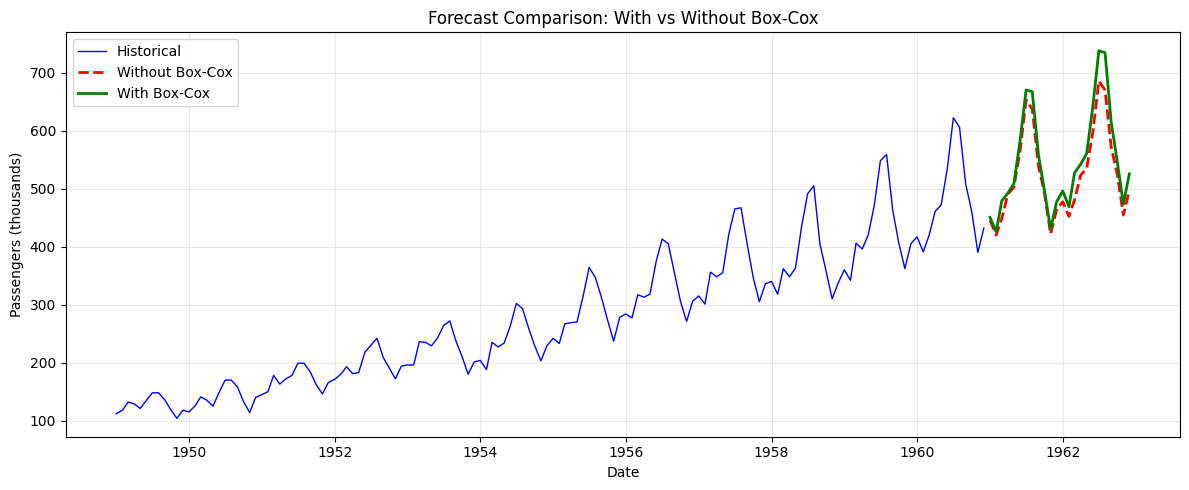

In [21]:
# Forecast with Box-Cox (back-transformation is automatic)
forecast_bc = forecast_arima(fit_boxcox, h=24)

# Compare with non-transformed forecast
plt.figure(figsize=(12, 5))

plt.plot(dates, air_passengers, 'b-', linewidth=1, label='Historical')

# Original forecast
plt.plot(forecast_dates, forecast['mean'], 'r--', linewidth=2, label='Without Box-Cox')

# Box-Cox forecast
plt.plot(forecast_dates, forecast_bc['mean'], 'g-', linewidth=2, label='With Box-Cox')

plt.title('Forecast Comparison: With vs Without Box-Cox')
plt.xlabel('Date')
plt.ylabel('Passengers (thousands)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Selected lambda: 0.0000


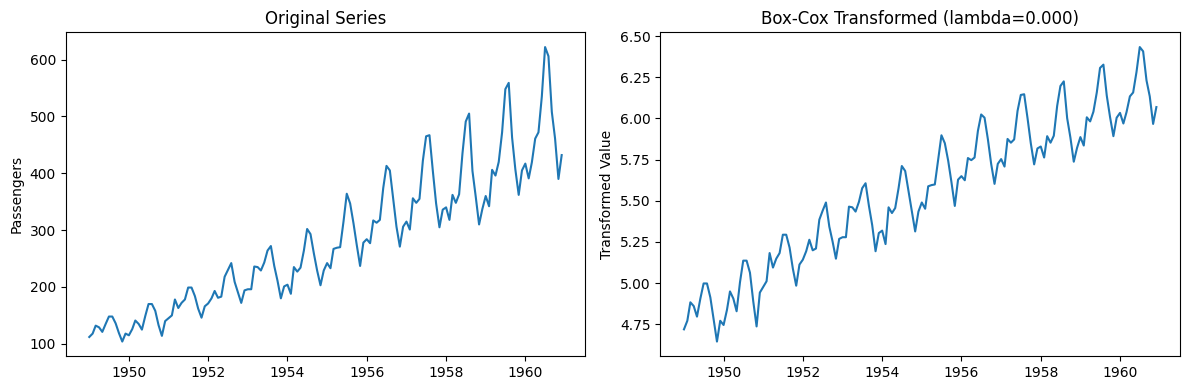

In [22]:
# Manual Box-Cox transformation
y_transformed, lambda_bc = box_cox(air_passengers, m=12, lambda_bc='auto')
print(f"Selected lambda: {lambda_bc:.4f}")

# Plot original vs transformed
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(dates, air_passengers)
axes[0].set_title('Original Series')
axes[0].set_ylabel('Passengers')

axes[1].plot(dates, y_transformed)
axes[1].set_title(f'Box-Cox Transformed (lambda={lambda_bc:.3f})')
axes[1].set_ylabel('Transformed Value')

plt.tight_layout()
plt.show()

<a id='exogenous'></a>
## 8. Exogenous Variables (ARIMAX)

Include external regressors in the model.

In [23]:
# Create exogenous variables (e.g., trend and seasonal dummies)
n = len(air_passengers)

# Time trend
trend = np.arange(1, n + 1).reshape(-1, 1)

# Monthly dummies (for demonstration - though seasonal ARIMA handles this)
months = np.tile(np.arange(1, 13), n // 12 + 1)[:n]

# Create xreg matrix
xreg = pd.DataFrame({
    'trend': np.arange(1, n + 1),
})

print("Exogenous variables shape:", xreg.shape)
display(xreg.head())

Exogenous variables shape: (144, 1)


,trend
0,1
1,2
2,3
3,4
4,5


In [24]:
# Fit ARIMAX model
fit_xreg = auto_arima(
    y=air_passengers,
    m=12,
    xreg=xreg,
    trace=True
)

print("\nCoefficients including exogenous:")
display(fit_xreg['coef'])

 ARIMA(2,1,2)(1,1,1)[12]                    : 1029.8041
 ARIMA(0,1,0)(0,1,0)[12]                    : 1034.4406
 ARIMA(1,1,0)(1,1,0)[12]                    : 1023.5309
 ARIMA(0,1,1)(0,1,1)[12]                    : 1024.1552
 ARIMA(1,1,0)(0,1,0)[12]                    : 1023.3816
 ARIMA(1,1,0)(0,1,1)[12]                    : 1024.0470
 ARIMA(1,1,0)(1,1,1)[12]                    : 1024.6191
 ARIMA(2,1,0)(0,1,0)[12]                    : 1025.5101
 ARIMA(1,1,1)(0,1,0)[12]                    : 1025.5101
 ARIMA(0,1,1)(0,1,0)[12]                    : 1023.6448
 ARIMA(2,1,1)(0,1,0)[12]                    : Inf

Best model found!

Coefficients including exogenous:


,ar1,trend
0,-0.307882,3.567074


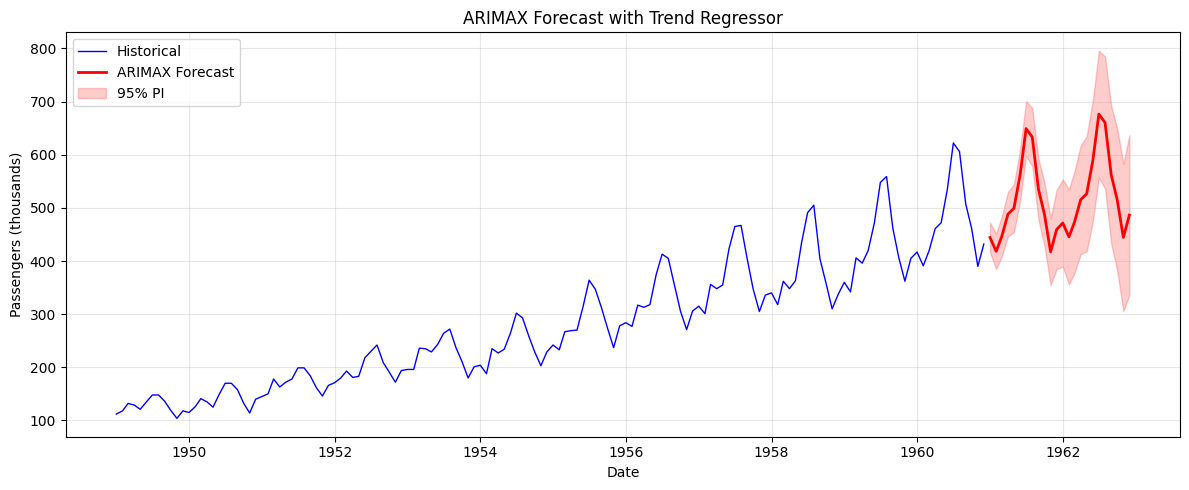

In [25]:
# Forecast with exogenous variables
# Need to provide future values of xreg
h = 24
xreg_future = pd.DataFrame({
    'trend': np.arange(n + 1, n + h + 1),
})

forecast_xreg = forecast_arima(fit_xreg, h=h, xreg=xreg_future)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(dates, air_passengers, 'b-', linewidth=1, label='Historical')
plt.plot(forecast_dates, forecast_xreg['mean'], 'r-', linewidth=2, label='ARIMAX Forecast')
plt.fill_between(forecast_dates, forecast_xreg['lower'][:, 1], forecast_xreg['upper'][:, 1], 
                 alpha=0.2, color='red', label='95% PI')
plt.title('ARIMAX Forecast with Trend Regressor')
plt.xlabel('Date')
plt.ylabel('Passengers (thousands)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<a id='stepwise'></a>
## 9. Stepwise vs Grid Search

By default, `auto_arima` uses stepwise search which is faster. You can also use exhaustive grid search.

In [26]:
import time

# Stepwise search (default - faster)
start = time.time()
fit_stepwise = auto_arima(
    y=air_passengers,
    m=12,
    stepwise=True,
    trace=False
)
time_stepwise = time.time() - start

print(f"Stepwise search:")
print(f"  Time: {time_stepwise:.2f}s")
print(f"  Model: ARIMA{tuple(fit_stepwise['arma'][:3])} x {tuple(fit_stepwise['arma'][3:6])}[{fit_stepwise['arma'][6]}]")
print(f"  AICc: {fit_stepwise['aicc']:.2f}")

Stepwise search:
  Time: 1.36s
  Model: ARIMA(2, 1, 0) x (0, 12, 1)[1]
  AICc: 1018.50


In [27]:
# Grid search (exhaustive - slower but more thorough)
start = time.time()
fit_grid = auto_arima(
    y=air_passengers,
    m=12,
    stepwise=False,
    max_p=2,
    max_q=2,
    max_P=1,
    max_Q=1,
    trace=False
)
time_grid = time.time() - start

print(f"Grid search:")
print(f"  Time: {time_grid:.2f}s")
print(f"  Model: ARIMA{tuple(fit_grid['arma'][:3])} x {tuple(fit_grid['arma'][3:6])}[{fit_grid['arma'][6]}]")
print(f"  AICc: {fit_grid['aicc']:.2f}")

print(f"\nSpeedup: {time_grid/time_stepwise:.1f}x slower for grid search")

Grid search:
  Time: 2.44s
  Model: ARIMA(2, 1, 0) x (0, 12, 1)[1]
  AICc: 1018.50

Speedup: 1.8x slower for grid search


## Summary

Key functions in the array interface:

| Function | Description |
|----------|-------------|
| `auto_arima(y, m, ...)` | Automatic ARIMA model selection |
| `forecast_arima(model, h, ...)` | Generate forecasts with prediction intervals |
| `arima(y, order, seasonal, m, ...)` | Fit ARIMA with specific orders |
| `ndiffs(x)` | Determine number of regular differences |
| `nsdiffs(x, period)` | Determine number of seasonal differences |
| `seas_heuristic(x, period)` | Compute seasonal strength |
| `box_cox(x, m, lambda_bc)` | Apply Box-Cox transformation |
| `inv_box_cox(x, lambda_bc)` | Reverse Box-Cox transformation |

### Key Parameters for `auto_arima`:

- `y`: Time series data (numpy array)
- `m`: Seasonal period (1 for non-seasonal)
- `d`, `D`: Fixed differencing orders (None for automatic)
- `max_p`, `max_q`, `max_P`, `max_Q`: Maximum orders to search
- `stepwise`: Use stepwise search (faster) or grid search
- `ic`: Information criterion ('aic', 'aicc', 'bic')
- `lambda_bc`: Box-Cox transformation ('auto', None, or float)
- `xreg`: Exogenous variables (DataFrame or ndarray)
- `trace`: Print search progress

In [28]:
# Final summary of best model
print("="*60)
print("FINAL MODEL SUMMARY")
print("="*60)
print(f"\nModel: ARIMA{tuple(fit['arma'][:3])} x {tuple(fit['arma'][3:6])}[{fit['arma'][6]}]")
print(f"\nCoefficients:")
display(fit['coef'])
print(f"\nFit Statistics:")
print(f"  sigma^2: {fit['sigma2']:.6f}")
print(f"  Log-likelihood: {fit['loglik']:.4f}")
print(f"  AIC: {fit['aic']:.4f}")
print(f"  AICc: {fit['aicc']:.4f}")
print(f"  BIC: {fit['bic']:.4f}")

FINAL MODEL SUMMARY

Model: ARIMA(2, 1, 0) x (0, 12, 1)[1]

Coefficients:


,ar1,ar2,ma1
0,0.597345,0.218983,-0.990052



Fit Statistics:
  sigma^2: 130.963242
  Log-likelihood: -505.0908
  AIC: 1018.1815
  AICc: 1018.4990
  BIC: 1029.6823
